# TP4 - Support Vector Machines

## 1 Hard Margin SVM

### MyHardMarginSVM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as copt
copt.solvers.options['show_progress'] = False

* Some tests for this class

In [264]:
class MyHardMarginSVM:
   
    def __init__(self):
        self._gram_mat = None # Contains the Gram matrix weighted by the labels
        self._lagranges = None # Contains the lagranges coefficients for each support vector
        self._w = None # Direction of the hyperplane
        self._bias = None # Contains the bias for each support vector

    def _compute_gram(self, data_train, labels):
        y = np.dot(labels.T, labels)
        x = np.dot(data_train.T, data_train).astype(float)
        return y * x;
        
    def train(self, data_train, labels):
        # Small value for float comparisons
        EPSILON = 1e-7
        
        self._gram_mat = self._compute_gram(data_train, labels)
        
        nb_samples = data_train.shape[1]
        
        #
        # In order to use the cvxopt library, we have to convert
        # numpy arrays to cvxopt matrices.
        #
        
        gram = copt.matrix(self._gram_mat)
        q = copt.matrix(-np.ones(nb_samples).T.astype(float))
        G = copt.matrix(-np.identity(nb_samples).T.astype(float))
        A = copt.matrix(labels.astype(float))
        h = copt.matrix(np.zeros(nb_samples).T.astype(float))
        b = copt.matrix(0.0)
        
        # Solves the dual problem using the cvxopt library
        trained = copt.solvers.qp(gram, q, G, h, A, b)
        
        lagranges = np.ravel(np.array(trained['x']))
        idx = (lagranges > EPSILON)
        self._lagranges = lagranges[idx]
        
        y = labels[:, idx]
        x = data_train[:, idx]
        self._nb_sv = x.shape[0]
        
        self._w = np.sum(self._lagranges * y * x, axis=1).reshape(-1, 1)
        self._bias = (1.0 / self._nb_sv) * np.sum(y - np.dot(self._w.T, x))

    def decision(self, data):
        return np.dot(self._w.T, data) + self._bias
        
    def process(self, data):
        dot = np.dot(self._w.T, data) + self._bias
        return np.sign(dot)
        
    def bias_get(self):
        return self._bias
        
    def lagrange_coeffs(self):
        return self._lagranges
    
    def get_nb_sv(self):
        return self._lagranges.shape[0]
        
    def print_2Ddecision(self, bounds, print_sv=True, print_non_sv=False):
        raise NotImplementedError

In [265]:
data = np.array([1, 2, 3]).reshape(1, 3)
labels = np.array([-1, 1, 1]).reshape(1, 3)

# Trains the SVM
hard_margin_svm = MyHardMarginSVM()
hard_margin_svm.train(data, labels)

# Test it on one sample
hard_margin_svm.decision(5)

# Test it on a set of samples
test_data = np.array([5, 0, -2]).reshape(1, 3)
excepted_labels = [1, -1, -1]

hard_margin_svm.process(test_data)


array([[ 1., -1., -1.]])

### 1.1 Very Tiny Toy

In [266]:
data = np.array([1, 2, 3]).reshape(1, 3)
labels = np.array([-1, 1, 1]).reshape(1, 3)

hard_margin_svm = MyHardMarginSVM()
hard_margin_svm.train(data, labels)
hard_margin_svm.decision(4)

array([[ 1.99999986]])

In [267]:
print("Number of support vectors for the previous example: {}".format(hard_margin_svm.get_nb_sv()))

Number of support vectors for the previous example: 2


In [268]:
print("Associated Lagrange value to each support vectors:")
print(hard_margin_svm.lagrange_coeffs())

Associated Lagrange value to each support vectors:
[ 1.99999986  1.99999986]


#### Regarding the above values

Here, we have 2 support vectors, for 3 samples. Two-thirds of our sample are support vectors, which seems to be too much. Having too many support vectors may be a sign of overfitting. I have difficulties to answer the question on how to find a better method to improve the results, because the dataset is really small.

### 1.2 2D Tiny Toy

In [269]:
import random

def gen_data(gen_func, size):
    nb_data = size
    min_x = 0
    max_x = 10
    min_y = 0
    max_y = 10
    
    # Generate train and labels
    x_1, y_1, x_2, y_2 = gen_func(nb_data, min_x, max_x, min_y, max_y)
    train = np.append(np.array((x_1, y_1)), np.array((x_2, y_2)), axis=1)
    labels = np.append(-np.ones(nb_data), np.ones(nb_data)).reshape(1, nb_data * 2)
    
    # Regenerate a new set for test
    x1_test, y1_test, x2_test, y2_test = gen_func(nb_data, min_x, max_x, min_y, max_y)
    test = np.append(np.array((x_1, y_1)), np.array((x_2, y_2)), axis=1)
    
    return train, test, labels, {'x1': x_1, 'x2': x_2, 'y1': y_1, 'y2': y_2}

def test_svm(svm, train, test, y):
    print('Training SVM with {} trains and {} tests'.format(train.shape, y.shape))
    svm.train(train, labels)
    print('SVM successfully trained!')
    output = svm.process(test)
    print()
    print('% of good classification:')
    print(((output == y).sum() / y.shape[1]) * 100.0)
    return output

# Generates random data. Both classes are linearly separable by a straight line.
def generate_data(n, min_x=0, max_x=10, min_y=0, max_y=10):
    x_1 = []
    x_2 = []
    y_1 = []
    y_2 = []
    
    # Generates data for lower-left part
    for i in range(0, n):
        x = random.uniform(min_x, max_x * 0.5) - random.uniform(min_x, max_x * 0.5) - max_x * 0.5
        y = max_y - random.uniform(0.5, max_y - x)
        x_1.append(x)
        y_1.append(y)
    
    # Generates data for lower-left part
    for i in range(0, n):
        x = random.uniform(min_x, max_x * 0.5) + random.uniform(min_x, max_x * 0.5) + max_x * 0.25
        y = max_y - random.uniform(0.5, max_y)
        x_2.append(x)
        y_2.append(y)

    return x_1, y_1, x_2, y_2
    

Display randomly generated 2D dataset:


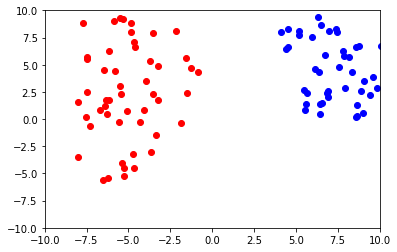

In [270]:
print("Display randomly generated 2D dataset:")
nb_data = 50

min_x = 0
max_x = 10
min_y = 0
max_y = 10

x_1, y_1, x_2, y_2 = generate_data(nb_data, min_x, max_x, min_y, max_y)

plt.xlim([-max_x, max_x])
plt.ylim([-max_y, max_y])
plt.plot(x_1, y_1, 'ro')
plt.plot(x_2, y_2, 'bo')

plt.show()

In [271]:
#train_data = np.append(np.array((x_1, y_1)), np.array((x_2, y_2)), axis=1)
#labels = np.append(-np.ones(nb_data), np.ones(nb_data)).reshape(1, nb_data * 2)
train_data, test_data, labels, raw_data = gen_data(generate_data, 50)
print(train_data.shape)
print (labels.shape)

(2, 100)
(1, 100)


In [272]:
svm = MyHardMarginSVM()
test_svm(svm, train_data, test_data, labels)

Training SVM with (2, 100) trains and (1, 100) tests
SVM successfully trained!

% of good classification:
100.0


array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

## 2 Noise

In [273]:
# Generates random data. Both classes are linearly separable by a straight line.
def generate_noisy_data(n, min_x=0, max_x=10, min_y=0, max_y=10):
    x_1 = []
    x_2 = []
    y_1 = []
    y_2 = []
    
    # Generates data for lower-left part
    for i in range(0, n):
        dispatch = random.uniform(0.8, 1.0)
        x = random.uniform(min_x, max_x * 0.5) - random.uniform(min_x, max_x * 0.5) - max_x * 0.5 * dispatch + 1.0
        y = max_y - random.uniform(0.5, max_y - x)
        x_1.append(x)
        y_1.append(y)
    
    # Generates data for lower-left part
    for i in range(0, n):
        dispatch = random.uniform(0.2, 0.3)
        x = random.uniform(min_x, max_x * 0.8) + random.uniform(min_x, max_x * 0.5) - dispatch * max_x * 0.25
        y = max_y - random.uniform(0.5, max_y)
        x_2.append(x)
        y_2.append(y)

    return x_1, y_1, x_2, y_2

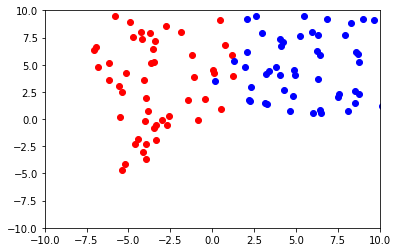

In [274]:
nb_data = 50

min_x = 0
max_x = 10
min_y = 0
max_y = 10

x_1, y_1, x_2, y_2 = generate_noisy_data(nb_data, min_x, max_x, min_y, max_y)

plt.xlim([-max_x, max_x])
plt.ylim([-max_y, max_y])
plt.plot(x_1, y_1, 'ro')
plt.plot(x_2, y_2, 'bo')

plt.show()

#### Test with hard margins

In [279]:
train_data, test_data, labels, raw_data = gen_data(generate_noisy_data, 50)

svm = MyHardMarginSVM()
test_svm(svm, train_data, test_data, labels)

Training SVM with (2, 100) trains and (1, 100) tests
SVM successfully trained!

% of good classification:
50.0


array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

Comparing to the previous test, where the data where easily linearly separable, we obtain here only 53% of good classification. The problem comes from the fact that hard margins tend to overfit to the data and to separate them to much. We could solve this by using soft margins, which tends to be more resistant to the noise. It looks like the SVM is quite broken actually, because in the case of a "huge" noise, all outputs seem to have the same value.

### Soft Margins SVM

In [280]:
class MySoftMarginSVM:
   
    def __init__(self):
        self._lagranges = None # Contains the lagranges coefficients for each support vector
        self._w = None # Direction of the hyperplane
        self._bias = None # Contains the bias for each support vector

    def _compute_gram(self, data_train, labels):
        y = np.dot(labels.T, labels)
        x = np.dot(data_train.T, data_train).astype(float)
        return y * x;
        
    def train(self, data_train, labels):
        # Small value for float comparisons
        EPSILON = 1e-7

        nb_samples = data_train.shape[1]
        
        #
        # In order to use the cvxopt library, we have to convert
        # numpy arrays to cvxopt matrices.
        #
        yy = np.dot(labels.T, labels)
        xx = np.dot(data_train.T, data_train)
        p = copt.matrix(yy * xx) # y_i * y_j * x_i.T * x_j
        
        q = copt.matrix(-np.ones(nb_samples).T.astype(float))
        G = copt.matrix(-np.identity(nb_samples).T.astype(float))
        A = copt.matrix(labels.astype(float))
        h = copt.matrix(np.zeros(nb_samples).T.astype(float))
        b = copt.matrix(0.0)
        
        # Solves the dual problem using the cvxopt library
        trained = copt.solvers.qp(p, q, G, h, A, b)
        
        lagranges = np.ravel(np.array(trained['x']))
        idx = (lagranges > EPSILON)
        self._lagranges = lagranges[idx]
        
        y = labels[:, idx]
        x = data_train[:, idx]
        self._nb_sv = x.shape[0]
        
        self._w = np.sum(self._lagranges * y * x, axis=1).reshape(-1, 1)
        self._bias = (1.0 / self._nb_sv) * np.sum(y - np.dot(self._w.T, x))

    def decision(self, data):
        return np.dot(self._w.T, data) + self._bias
        
    def process(self, data):
        dot = np.dot(self._w.T, data) + self._bias
        return np.sign(dot)
        
    def bias_get(self):
        return self._bias
        
    def lagrange_coeffs(self):
        return self._lagranges
    
    def get_nb_sv(self):
        return self._lagranges.shape[0]
        
    def print_2Ddecision(self, bounds, print_sv=True, print_non_sv=False):
        raise NotImplementedError

Training SVM with (2, 100) trains and (1, 100) tests
SVM successfully trained!

% of good classification:
77.0


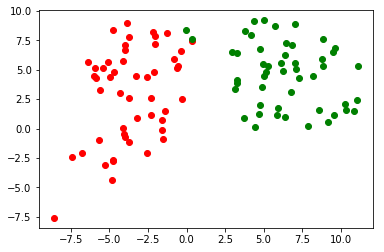

In [281]:
train_data, test_data, labels, raw_data = gen_data(generate_noisy_data, 50)

soft_svm = MySoftMarginSVM()
out = test_svm(soft_svm, train_data, test_data, labels)

plt.plot(raw_data['x1'], raw_data['y1'], 'ro')
plt.plot(raw_data['x2'], raw_data['y2'], 'go')
        
plt.show()

## 3 MultiClass Management

## 4 Unbalanced Dataset